<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    with open(site_freq_path, 'rb') as s:
        d = pickle.load(s)

    X = []
    y = []
    
    files = os.listdir(path_to_csv_files)
    
    n = 0
    
    start_hour = []
    day_of_week = []
    time = []
    time_diff = []
    session_timespan = []
    unique_sites = []
    
    for i in tqdm(range(len(files))):
        a1 = list(pd.read_csv(os.path.join(path_to_csv_files, files[i])).site)
        b1 = list(pd.read_csv(os.path.join(path_to_csv_files, files[i])).timestamp)

        
        for s in range((len(b1)-1)):
            t1 = pd.to_datetime(b1[s])
            t2 = pd.to_datetime(b1[s+1])
            time.append((t2-t1).total_seconds())
        
        
        for  l, k in enumerate(a1):
            a1[l] = d[k][0]
        while len(a1)!=0:
            if len(a1)>session_length:                
                X.append(a1[0:session_length])
                y.append(i+1)
                n = n+1
                start_hour.append(pd.to_datetime(b1[0]).hour)
                day_of_week.append(pd.to_datetime(b1[0]).dayofweek)
                time_diff.append(time[0:(session_length-1)])
                session_timespan.append(sum(time[0:(session_length-1)]))
                unique_sites.append(len(set(a1[0:session_length])))
            else:
                X.append((a1[0:len(a1)]+[0]*(session_length-len(a1))))
                y.append(i+1)
                n = n+1
                start_hour.append(pd.to_datetime(b1[0]).hour)
                day_of_week.append(pd.to_datetime(b1[0]).dayofweek)
                time_diff.append(time[0:(len(a1)-1)]+([0]*(session_length-len(a1))))
                session_timespan.append(sum(time[0:(session_length-1)]))
                unique_sites.append(len(set(a1[0:len(a1)])))
            del a1[0:window_size]
            del b1[0:window_size]
            del time[0:window_size]
    
    m =  np.column_stack((np.array(X), np.array(time_diff), np.array(session_timespan), np.array(unique_sites), 
                          np.array(start_hour), np.array(day_of_week), np.array(y)))
    
    return pd.DataFrame(m, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  6.17it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                     feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:45<00:00,  4.49s/it]


Wall time: 45.5 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5.0,8.0,4.0,1.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10.0,8.0,4.0,1.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7.0,8.0,4.0,1.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6.0,8.0,4.0,1.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9.0,8.0,4.0,1.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                     feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████| 150/150 [07:10<00:00,  2.28s/it]


Wall time: 7min 11s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
np.median(train_data_10users['session_timespan'])

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
np.median(train_data_10users['day_of_week'])

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
np.median(train_data_150users['start_hour'])

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

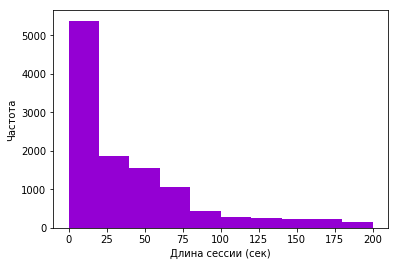

In [17]:
plt.hist(train_data_10users[train_data_10users.session_timespan<=200]['session_timespan'], color='darkviolet')
plt.xlabel(u'Длина сессии (сек)')
plt.ylabel(u'Частота')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

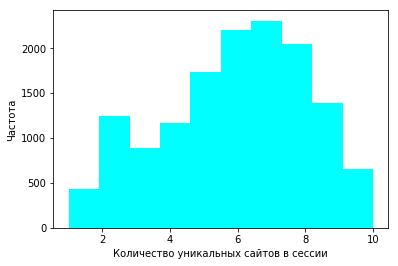

In [18]:
plt.hist(train_data_10users['#unique_sites'], color='aqua')
plt.xlabel(u'Количество уникальных сайтов в сессии')
plt.ylabel(u'Частота')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

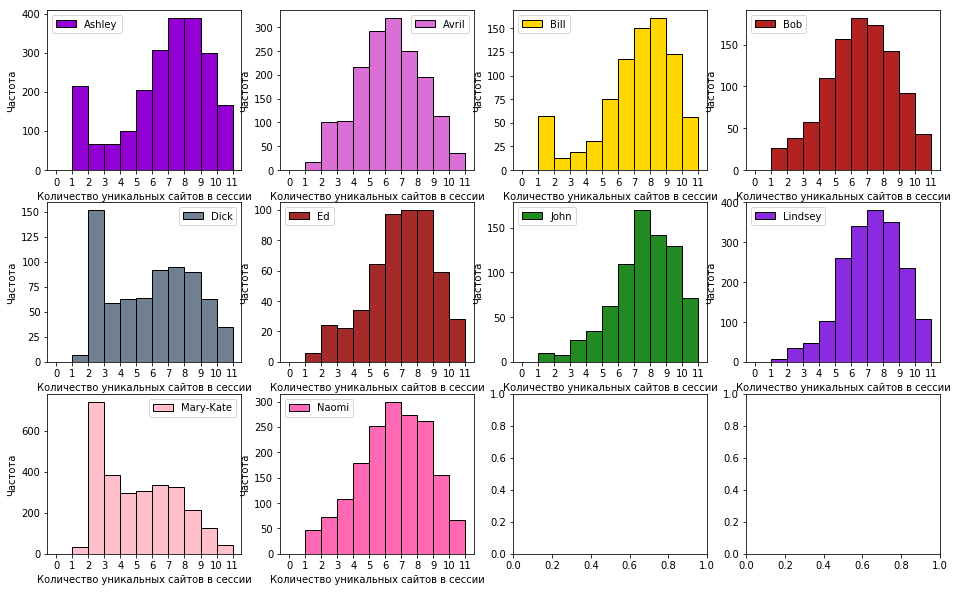

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['#unique_sites'], color=color_dic[user], edgecolor='black', label=user, bins=range(12))
    plt.xlabel(u'Количество уникальных сайтов в сессии')
    plt.ylabel(u'Частота')
    a.set_xticks(range(12))
    plt.legend ()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

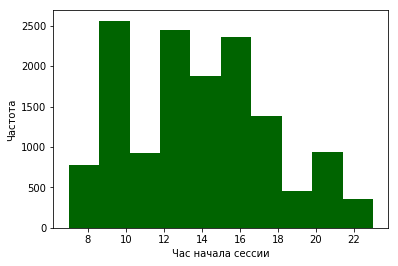

In [20]:
plt.hist(train_data_10users['start_hour'], color='darkgreen')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Частота')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

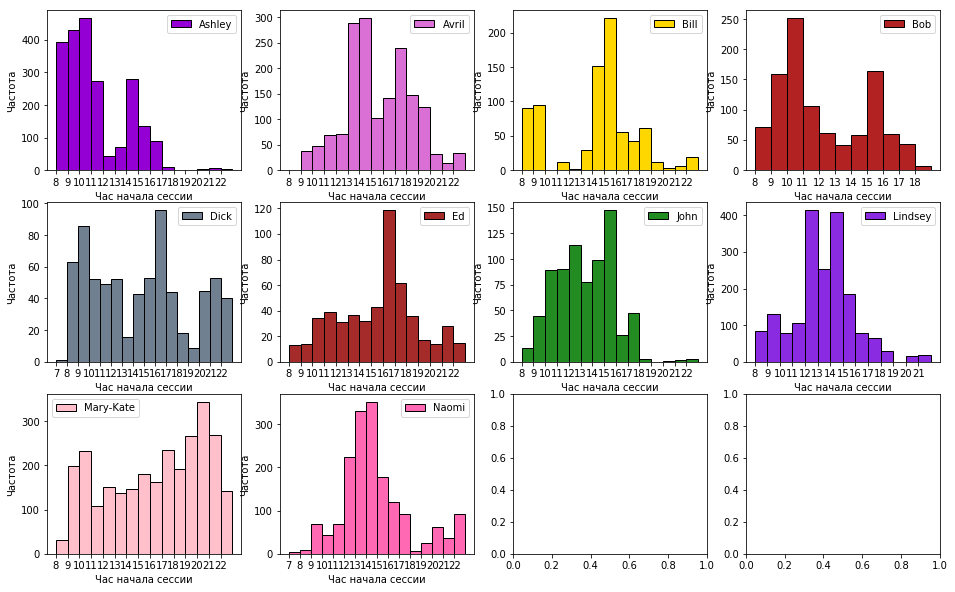

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    bins = range(int(sub_df['start_hour'].min()), int(np.ceil(sub_df['start_hour'].max())) + 1)
    plt.hist(sub_df['start_hour'], color=color_dic[user], edgecolor='black', label=user, bins=bins)
    a.set_xticks(range(int(sub_df['start_hour'].min()),int(sub_df['start_hour'].max())))
    plt.xlabel(u'Час начала сессии')
    plt.ylabel(u'Частота')
    plt.legend ()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

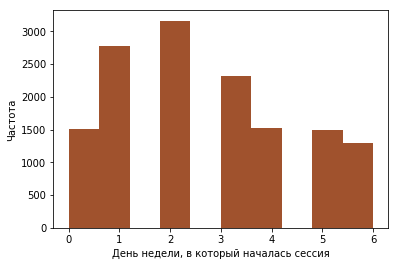

In [22]:
plt.hist(train_data_10users['day_of_week'], color='sienna')
plt.xlabel(u'День недели, в который началась сессия')
plt.ylabel(u'Частота')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

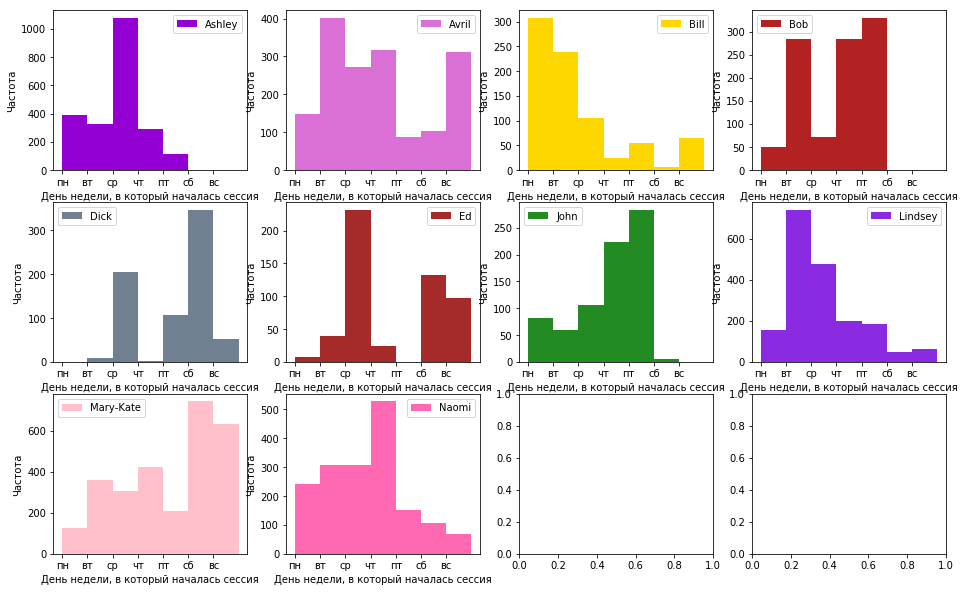

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
days = [u'пн', u'вт', u'ср', u'чт', u'пт', u'сб', u'вс']
for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    
    plt.hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins = range(0, 8))
    a.set_xticks(range(0, 7))
    a.set_xticklabels(days)
    plt.xlabel(u'День недели, в который началась сессия')
    plt.ylabel(u'Частота')
    plt.legend ()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley: За сессию чаще всего заходит на 7-8 уникальных сайтов, посещает сайты утром и днем, но гораздо чаще утром (с 8 до 11), только в будние дни (наиболее часто в среду).

Avril: За сессию чаще всего заходит на 6 уникальных сайтов, посещает сайты на протяжении всей недели и всего дня, чаще во вторник, реже - в пятницу и субботу, чаще с 14-15 и в 17 часов.

Bill: За сессию чаще всего заходит на 8 уникальных сайтов, чаще посещает сайты 13-15, в первой половине недели ( чаще всего в понедельник).

Bob: За сессию чаще всего заходит на 6 уникальных сайтов, чаще посещает сайты в 10 часов , только в будние дни (наиболее часто во вторник, четверг, пятницу).

Dick: За сессию чаще всего заходит на 2 уникальных сайтов, чаще посещает сайты в 9 часов и в 16 часов. Наибольшая активность в субботу. В понедельник сайты не посещает.

Ed: За сессию чаще всего заходит на 7-8 уникальных сайтов, чаще посещает сайты в 16 часов. Достаточно часто посещает сайты в выходные, но чаще в среду. В пятницу сайты не посещает.  

John: За сессию чаще всего заходит на 7 уникальных сайтов, чаще посещает сайты в 15 часов. Наибольшая активность в пятницу, в воскресенье сайты не посещает.

Lindsey: За сессию чаще всего заходит на 7 уникальных сайтов, чаще посещает сайты в 12 часов и в 14 часов. Посещает сайты на протяжении всей недели, чаще во вторник

Mary-Kate: За сессию чаще всего заходит на 2 уникальных сайтов, самый активный пользователь, посещает сайты на протяжении всего дня и всей недели, чуть чаще в 20 часов и в выходные дни.

Naomi: За сессию чаще всего заходит на 6 уникальных сайтов, чаще посещает сайты 13-15. Посещает сайты на протяжении всей недели, чаще в четверг.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as s:
        d = pickle.load(s)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
from collections import Counter, OrderedDict, defaultdict
s = OrderedDict(sorted(d.items(), key=lambda (k, (v1, v2)): v2, reverse=True)[:10])
top10_sites = s.keys()

In [26]:
top10_freqs = []
for i in top10_sites:
    top10_freqs.append(d[i][1])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

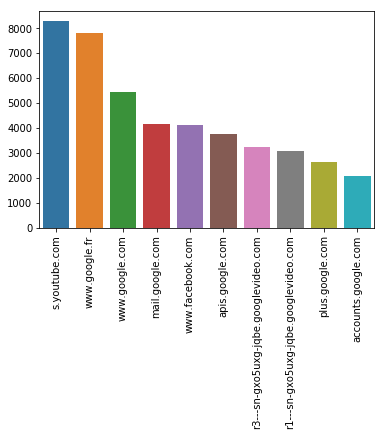

In [27]:
b = sns.barplot(top10_sites, top10_freqs)
b.set_xticklabels(top10_sites, rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
def new_feature(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    
    #создание двух новых признаков: 
    #сайт с максимальным временем пребывания (за сессию), 
    #сайт наиболее часто встречающийся за сессию(если таких несколько, то первый из них)
    
    with open(site_freq_path, 'rb') as s:
        d = pickle.load(s)

    files = os.listdir(path_to_csv_files)

    time = []
    site_max_time = []
    site_max_count = []

    for i in tqdm(range(len(files))):
        a1 = list(pd.read_csv(os.path.join(path_to_csv_files, files[i])).site)
        b1 = list(pd.read_csv(os.path.join(path_to_csv_files, files[i])).timestamp)

        for s in range((len(b1)-1)):
            t1 = pd.to_datetime(b1[s])
            t2 = pd.to_datetime(b1[s+1])
            time.append((t2-t1).total_seconds())

        for  l, k in enumerate(a1):
            a1[l] = d[k][0]

        while len(a1)!=0:
            if len(a1)>session_length:
                X = a1[0:session_length]
                X_set = set(X)
                m = None
                q_max = 0
                for item in X_set:
                    q = X.count(item)
                    if q > q_max:
                        q_max = q
                        m = item
                site_max_count.append(m)
                time_diff = time[0:(session_length-1)]
                if max(time_diff)!=0:
                    site_max_time.append(X[time_diff.index(max(time_diff))])
                else:
                    site_max_time.append(0)
            else:
                X = (a1[0:len(a1)]+[0]*(session_length-len(a1)))
                X_set = set(X)
                m = None
                q_max = 0
                for item in X_set:
                    q = X.count(item)
                    if q > q_max:
                        q_max = q
                        m = item
                site_max_count.append(m)
                time_diff = time[0:(len(a1)-1)]+([0]*(session_length-len(a1)))
                if max(time_diff)!=0:
                    site_max_time.append(X[time_diff.index(max(time_diff))])
                else:
                    site_max_time.append(0)

            del a1[0:window_size]
            del b1[0:window_size]
            del time[0:window_size]
     
    return site_max_time, site_max_count

In [29]:
def new_feature1(path_to_csv_files, session_length=10, window_size=10):
    
    #создание признаков: количество сайтов за сессию с расширением .com, .net, .org, .fr
   
    files = os.listdir(path_to_csv_files)

    com_count = []
    net_count = []
    org_count = []
    fr_count = []

    for i in tqdm(range(len(files))):
        a1 = list(pd.read_csv(os.path.join(path_to_csv_files, files[i])).site)
      
        while len(a1)!=0:
            if len(a1)>session_length:
                s = a1[0:session_length]
                o = []
                for k in range(len(s)):
                    o.append(s[k].split('.')[-1])
                
                com_count.append(o.count('com'))
                net_count.append(o.count('net'))
                org_count.append(o.count('org'))
                fr_count.append(o.count('fr'))
                
            else:
                s = a1[0:len(a1)]
                o = []
                for k in range(len(s)):
                    o.append(s[k].split('.')[-1])
                
                com_count.append(o.count('com'))
                net_count.append(o.count('net'))
                org_count.append(o.count('org'))
                fr_count.append(o.count('fr'))
                
            del a1[0:window_size]
     
    return  com_count, net_count, org_count, fr_count

In [41]:
def feature_engineering(data, path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    df = data
    site_max_time, site_max_count = new_feature(path_to_csv_files, site_freq_path, session_length, window_size)
    com_count, net_count, org_count, fr_count = new_feature1(path_to_csv_files, session_length, window_size)
    df['site_max_count']=site_max_count
    df['site_max_time']=site_max_time
    df['com_count']=com_count
    df['net_count']=net_count
    df['org_count']=org_count
    df['fr_count']=fr_count
    return df

In [42]:
new_features_10users = feature_engineering(train_data_10users, os.path.join(PATH_TO_DATA, '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 16.61it/s]


In [43]:
new_features_150users = feature_engineering(train_data_150users, os.path.join(PATH_TO_DATA, '150users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), session_length=10)

100%|████████████████████████████████████████| 150/150 [00:06<00:00, 29.40it/s]


In [44]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,site_max_count,site_max_time,com_count,net_count,org_count,fr_count
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,...,0.0,33.0,5.0,8.0,4.0,John,3,3,3,7,0,0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,...,8.0,284.0,10.0,8.0,4.0,John,3,8,7,3,0,0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,...,0.0,258.0,7.0,8.0,4.0,John,14,14,6,4,0,0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,...,0.0,30.0,6.0,8.0,4.0,John,14,14,2,8,0,0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,...,0.0,6.0,9.0,8.0,4.0,John,29,24,3,4,1,0


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

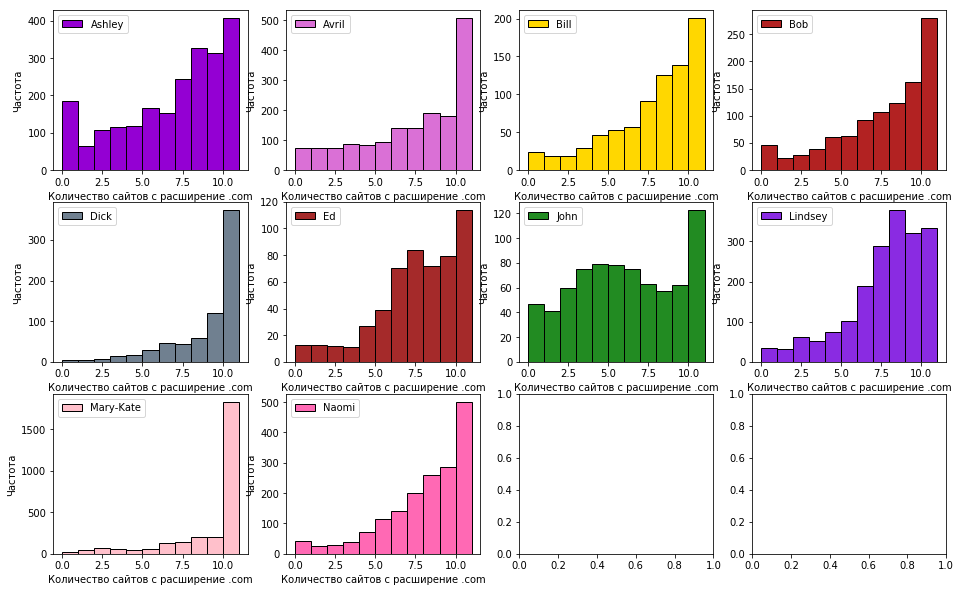

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['com_count'], color=color_dic[user], edgecolor='black', label=user, bins=range(12))
    plt.xlabel(u'Количество сайтов с расширение .com')
    plt.ylabel(u'Частота')
    plt.legend ()

Гистограммы данного признака для каждого пользователя отличаются. Можно попробовать использовать этот признак для идентификации пользователей.

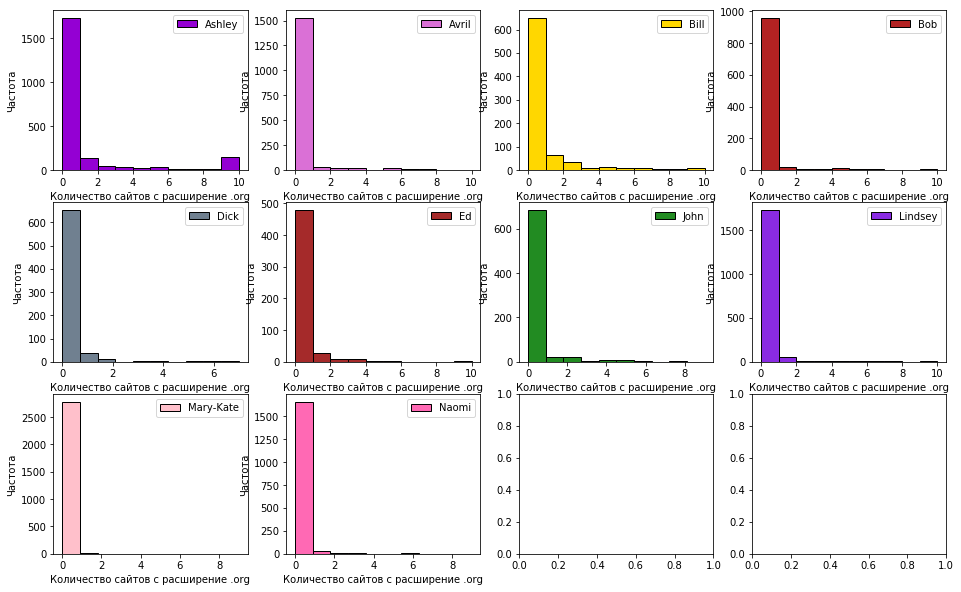

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['org_count'], color=color_dic[user], edgecolor='black', label=user)
    plt.xlabel(u'Количество сайтов с расширение .org')
    plt.ylabel(u'Частота')
    plt.legend ()

Гистограммы данного признака почти одинаковые для каждого пользователя. Большинство сессий не имеют сайтов с расширением .org. Этот признак скорее всего не будет влиять на идентификацию пользователей.

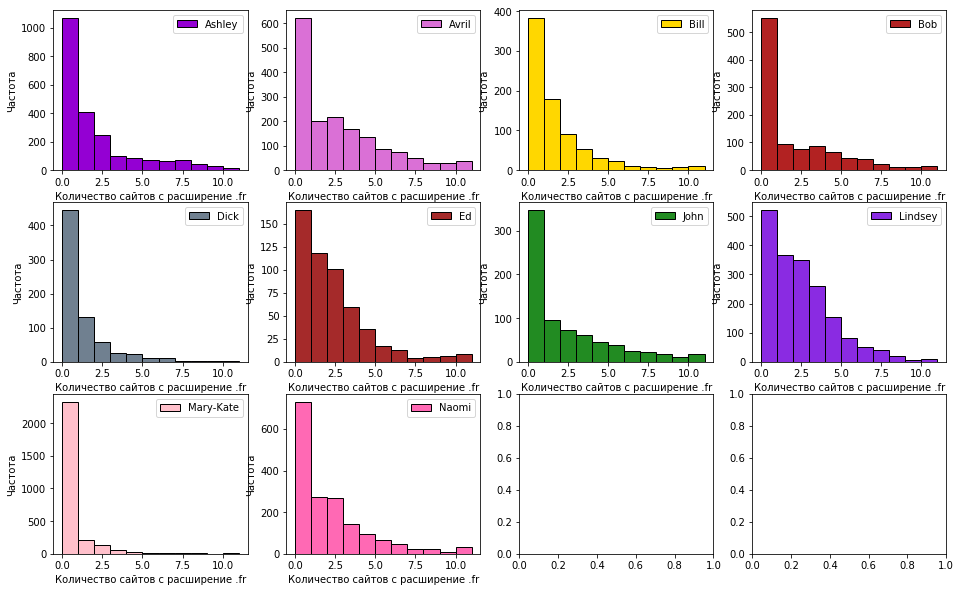

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['fr_count'], color=color_dic[user], edgecolor='black', label=user, bins=range(12))
    plt.xlabel(u'Количество сайтов с расширение .fr')
    plt.ylabel(u'Частота')
    plt.legend ()

Есть отличия в гистограммах данного признака для разных пользователей. Конечно, различия были бы существенней, если пользователи были бы из разных стран. Можно попробовать использовать данный признак для построения моделей.

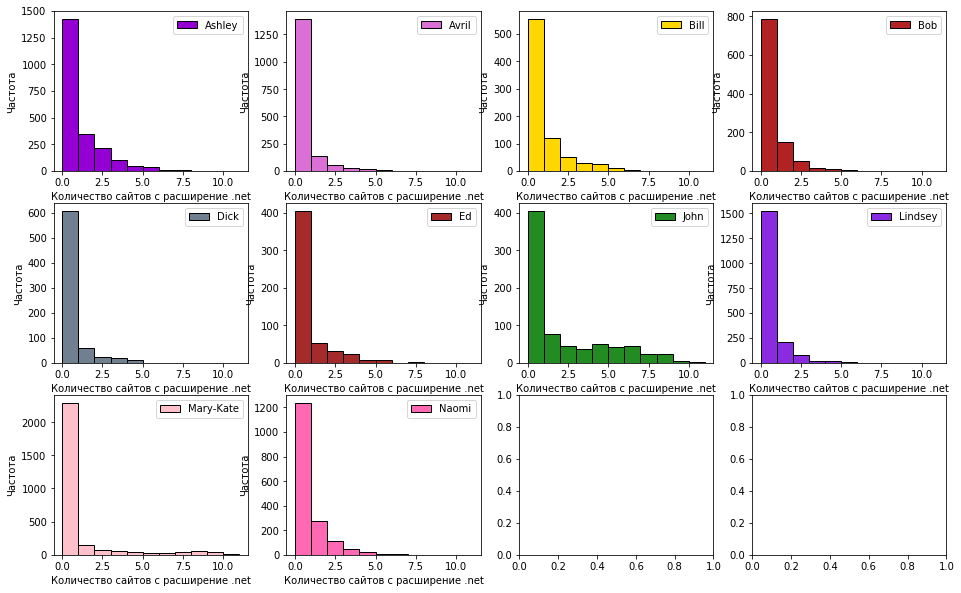

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['net_count'], color=color_dic[user], edgecolor='black', label=user, bins=range(12))
    plt.xlabel(u'Количество сайтов с расширение .net')
    plt.ylabel(u'Частота')
    plt.legend ()

Гистограммы данного почти одинаковые для каждого пользователя. Есть совсем небольшие отличия от пользователя к пользователю.

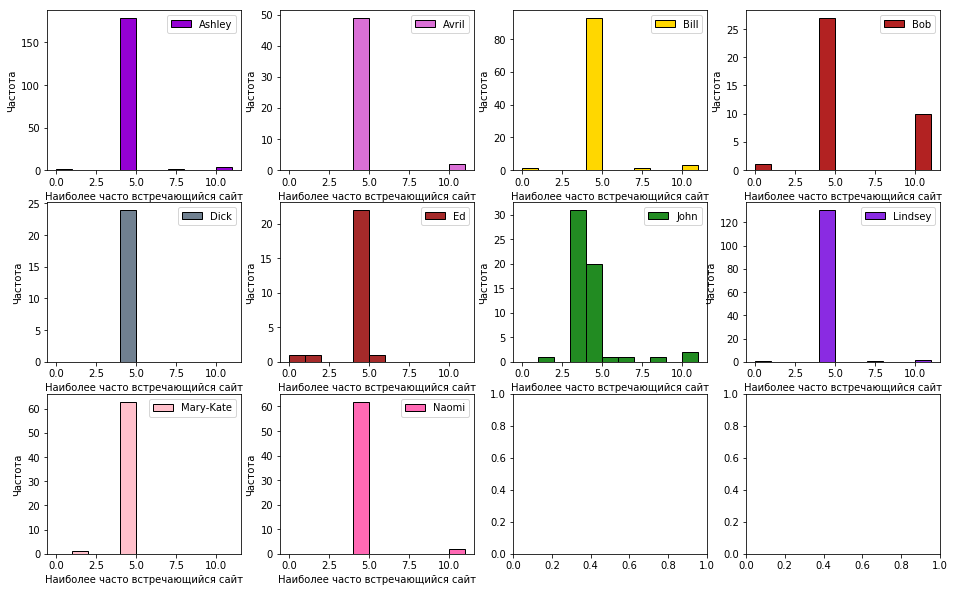

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['site_max_count'], color=color_dic[user], edgecolor='black', label=user, bins=range(12))
    plt.xlabel(u'Наиболее часто встречающийся сайт')
    plt.ylabel(u'Частота')
    plt.legend ()

Данный признак почти никак не меняется от пользователя к пользователю. Возможно при более длинной сессии по количеству сайтов признак показал бы различия для разных пользователей. Но пока не будем его использовать для идентицикации пользователей

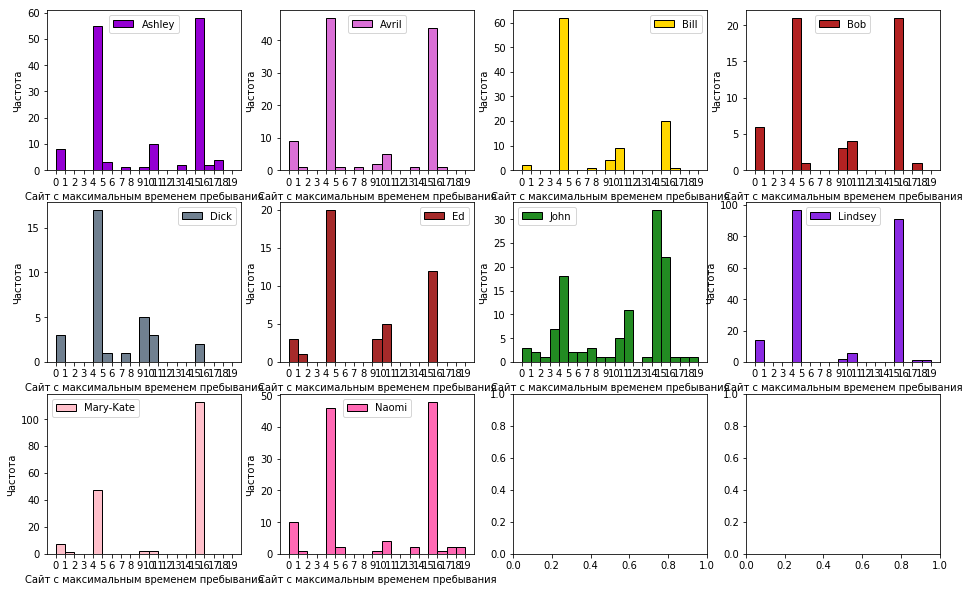

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate (pd.groupby(new_features_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['site_max_time'], color=color_dic[user], edgecolor='black', label=user, bins=range(20))
    a.set_xticks(range(0, 20))
    plt.xlabel(u'Cайт с максимальным временем пребывания') 
    plt.ylabel(u'Частота')
    plt.legend ()

Можно увидеть различия в гистограммах для сайтов с максимальным временем пребывания за сессию. Можно попробовать его использовать для идентификации пользователей. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [51]:
selected_features_10users = new_features_10users[['session_timespan', '#unique_sites', 'start_hour',
                                                  'day_of_week', 'com_count', 'fr_count', 'net_count', 'site_max_time']]
selected_features_150users = new_features_10users[['session_timespan', '#unique_sites', 'start_hour',
                                                  'day_of_week', 'com_count', 'fr_count', 'net_count', 'site_max_time']]

In [52]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 